<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/Reproduction_training_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data

from tqdm.auto import tqdm
import random as rng

import numpy as np
import scipy as sp
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.stats import norm

In [2]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same.
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [3]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [4]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))
    return tensored_qubits[-1]

In [5]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [6]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])

    return POVM

In [7]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    """
    probabilities = []
    for element in POVM:
        #probabilities.append(np.trace(element@state))
        probabilities.append(np.trace(np.einsum('ij,jk->ik',element,state,optimize=True)))
        #probabilities.append(np.einsum('ll',np.einsum('ij,jk->ik',element,state,optimize=True),optimize=True).real)
    return probabilities

In [8]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [9]:
def sampling(probabilities,samplesize):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [10]:
def MLE(nQubits,calibration_states,noisy_probabilities,POVM_ideal,p,samplesize):
    '''
    calibration_states: axis 0 = state, axis 1 = row, axis 2 = column
    noisy_probabilities: axis 0 = state, axis 1 = probabilities
    POVM_ideal / _reconstructed: axis 0 = element, axis 1 = row, axis 2 = column
    numb_of_detections: axis 0 = POVM_element, axis 1 = states, values = counts
    p_ideal: axis 0 = POVM_element, axis 1 = states, values = current ideal probability
    fracs: axis 0 = POVM_element, axis 1 = states, values = fractions

    '''

    numb_of_detections = noisy_probabilities.T * samplesize

    loop_num = 0
    loop_max = 2*10**3
    dist = 1
    dist_min = 10**-9

    POVM_reconstructed = np.array([p/2**nQubits*np.eye(2**nQubits) + (1-p)*POVM_elem for POVM_elem in POVM_ideal])

    while loop_num < loop_max and dist > dist_min:

        #p_ideal = np.array([perform_multi_qubit_measurement(state,POVM_reconstructed) for state in calibration_states]).T
        p_ideal = np.einsum('moll->mo',np.einsum('nij,ljk->nlik',POVM_reconstructed,calibration_states,optimize=True),optimize=True)
        #np.trace(element@state)
        #np.einsum('ll',np.einsum('ij,jk->ik',element,state,optimize=True),optimize=True).real
        fracs = numb_of_detections/p_ideal

        G = np.einsum('lm,ln,nij,ljk,mko->io',fracs,fracs,calibration_states,POVM_reconstructed,calibration_states,optimize=True)

        eig_vals,U = sp.linalg.eig(G)
        l_sqrt_inv = np.diag(1/np.sqrt(eig_vals))
        l_inv = U@l_sqrt_inv@U.conj().T # -> why not as in paper: U_dagger L_sqrt U ???

        R = np.einsum('ij,lm,mjk->lik',l_inv,fracs,calibration_states,optimize=True)

        POVM_reconstruction_old = POVM_reconstructed
        #POVM_reconstructed = np.einsum('lij,ljk,lkm->lim',R,POVM_reconstructed,R.conj().T)
        POVM_reconstructed = np.einsum('lij,ljk,lmk->lim',R,POVM_reconstructed,R.conj(),optimize=True)

        dist = np.sum([np.linalg.norm(POVM_reconstructed-POVM_reconstruction_old)])

        #if loop_num % (120/nQubit) == 0:
        if loop_num % 50 == 0:
            print(f'loop number: {loop_num}, distance: {dist}')

        loop_num += 1

    print(f'final loop number: {loop_num}, final distance: {dist}')

    return POVM_reconstructed, dist

In [11]:
def loss_fn(state, params, batch_input, batch_target_output):
    predictions = state.apply_fn(params, batch_input)
    #loss = jnp.mean(optax.softmax_cross_entropy(predictions,batch_target_output))
    loss = jnp.mean(-jnp.sum(batch_target_output*jax.lax.log(predictions),axis=1))
    return loss

In [12]:
@jax.jit
def accuracy_MSE(acc_input, acc_target_output,nQubit):
  acc = jnp.mean(jnp.sum(jnp.abs(acc_input-acc_target_output)**2,axis=-1)/(2**nQubit))
  return acc

In [13]:
@jax.jit
def accuracy_KLD(acc_input, acc_target_output):
  acc = jnp.mean(jnp.sum(acc_target_output*jnp.log(acc_target_output/acc_input),axis=-1))
  return acc

In [14]:
@jax.jit
def accuracy_IF(acc_input, acc_target_output):
  acc = jnp.mean(1-(jnp.sum(jnp.sqrt(acc_target_output*acc_input),axis=-1))**2)
  return acc

In [15]:
def linear_inversion(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize,desired_probabilities,test_probs,desired_test_probs):
    '''

    '''

    POVM_recon, dist = MLE(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize)

    L = np.zeros((2**nQubit,2**nQubit))

    for i in range(2**nQubit):
        for j in range(2**nQubit):
            L[j][i] = POVM_recon[i][j][j]

    L_inv = np.linalg.inv(L)

    probs_cor = np.einsum('ij,lj->li',L_inv,test_probs,optimize=True)
    probs_cor_tr = np.einsum('ij,lj->li',L_inv,calibration_probabilities,optimize=True)

    acc_MSE = accuracy_MSE(probs_cor, desired_test_probs,nQubit)
    acc_MSE_tr = accuracy_MSE(probs_cor_tr, desired_probabilities,nQubit)

    acc_KLD = accuracy_KLD(probs_cor, desired_test_probs)
    acc_KLD_tr = accuracy_KLD(probs_cor_tr, desired_probabilities)

    acc_IF = accuracy_IF(probs_cor, desired_test_probs)
    acc_IF_tr = accuracy_IF(probs_cor_tr, desired_probabilities)

    return L_inv, POVM_recon, probs_cor, [acc_MSE,acc_MSE_tr], [acc_KLD,acc_KLD_tr], [acc_IF,acc_IF_tr]

In [16]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output):
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [17]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output,nQubit, num_epochs = 100):

  acc_test_MSE = []
  acc_training_MSE = []
  acc_unmitigated_test_MSE = []

  acc_test_KLD = []
  acc_training_KLD = []
  acc_unmitigated_test_KLD = []

  acc_test_IF = []
  acc_training_IF = []
  acc_unmitigated_test_IF = []

  for epoch in tqdm(range(num_epochs)):
    for i in range(len(batched_training_input)):
      state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i])

    predictions_test = state.apply_fn(state.params, acc_input)
    predictions_training = state.apply_fn(state.params, batched_training_input)

    acc_test_MSE.append(accuracy_MSE(predictions_test, acc_target_output,nQubit))
    acc_training_MSE.append(accuracy_MSE(predictions_training, batched_training_target_outputs,nQubit))
    acc_unmitigated_test_MSE.append(accuracy_MSE(acc_input, acc_target_output,nQubit))

    acc_test_KLD.append(accuracy_KLD(predictions_test, acc_target_output))
    acc_training_KLD.append(accuracy_KLD(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_KLD.append(accuracy_KLD(acc_input, acc_target_output))

    acc_test_IF.append(accuracy_IF(predictions_test, acc_target_output))
    acc_training_IF.append(accuracy_IF(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_IF.append(accuracy_IF(acc_input, acc_target_output))

  return state, [acc_test_MSE, acc_training_MSE, acc_unmitigated_test_MSE], [acc_test_KLD, acc_training_KLD, acc_unmitigated_test_KLD], [acc_test_IF, acc_training_IF, acc_unmitigated_test_IF]

In [18]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [19]:
class MLP(nn.Module):

  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)


  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation) # tell how to initialize weigths -> reduce variance
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation)
    return jax.nn.softmax(activation)

  0%|          | 0/36 [00:00<?, ?it/s]

/usr/lib/python3.10/random.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  if not _isfinite(total):
<ipython-input-20-eec4e5ea55fd>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]
<ipython-input-20-eec4e5ea55fd>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.006483577415070863
loop number: 50, distance: 7.005705091944968e-05
loop number: 100, distance: 1.4803718210993767e-05
loop number: 150, distance: 4.136891964609339e-06
loop number: 200, distance: 1.2351557552030407e-06
loop number: 250, distance: 3.754979341832777e-07
loop number: 300, distance: 1.1486504409515746e-07
loop number: 350, distance: 3.522833582578186e-08
loop number: 400, distance: 1.0818069851204605e-08
loop number: 450, distance: 3.32443529346563e-09
loop number: 500, distance: 1.022059284905456e-09
final loop number: 502, final distance: 9.98234841997314e-10


<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004435403177093504
loop number: 50, distance: 4.134692641174021e-05
loop number: 100, distance: 6.127116848970781e-06
loop number: 150, distance: 1.0442088654242966e-06
loop number: 200, distance: 1.9501063056542894e-07
loop number: 250, distance: 3.9520153475267485e-08
loop number: 300, distance: 8.505909735579653e-09
loop number: 350, distance: 1.8987191749594503e-09
final loop number: 373, final distance: 9.883244600568755e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0046492317738630155
loop number: 50, distance: 1.1156553903104659e-05
loop number: 100, distance: 9.734876815905452e-07
loop number: 150, distance: 1.386038972982973e-07
loop number: 200, distance: 2.0597372376989495e-08
loop number: 250, distance: 3.0858590928455557e-09
final loop number: 281, final distance: 9.894577280486384e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0031620153173901517
loop number: 50, distance: 1.456278324702982e-05
loop number: 100, distance: 1.5127527244491942e-06
loop number: 150, distance: 1.7321454071094612e-07
loop number: 200, distance: 2.050471554483598e-08
loop number: 250, distance: 2.4662582551016616e-09
final loop number: 273, final distance: 9.740144726518772e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004430056941537839
loop number: 50, distance: 1.5981668190011014e-05
loop number: 100, distance: 1.969233842281812e-06
loop number: 150, distance: 2.586870467629032e-07
loop number: 200, distance: 3.448004353106342e-08
loop number: 250, distance: 4.6297976132470055e-09
final loop number: 290, final distance: 9.702904909616672e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0036096492185037294
loop number: 50, distance: 1.956623129012682e-05
loop number: 100, distance: 2.0531372861014625e-06
loop number: 150, distance: 2.1969292262011048e-07
loop number: 200, distance: 2.352345684216096e-08
loop number: 250, distance: 2.519252790731289e-09
final loop number: 272, final distance: 9.858132924620933e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003028160279674438
loop number: 50, distance: 9.729985041769775e-06
loop number: 100, distance: 1.073830726732418e-06
loop number: 150, distance: 1.237771577406258e-07
loop number: 200, distance: 1.4391085219350691e-08
loop number: 250, distance: 1.6815746792862417e-09
final loop number: 264, final distance: 9.627956456750652e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0028260508660506514
loop number: 50, distance: 1.4433599382308284e-05
loop number: 100, distance: 1.416955972242201e-06
loop number: 150, distance: 1.4090886861525552e-07
loop number: 200, distance: 1.4106959690090102e-08
loop number: 250, distance: 1.4183489520924188e-09
final loop number: 259, final distance: 9.823846959522489e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00208337841479178
loop number: 50, distance: 1.457717189207896e-05
loop number: 100, distance: 1.6923671110061606e-06
loop number: 150, distance: 2.0380061829531367e-07
loop number: 200, distance: 2.4807578834894033e-08
loop number: 250, distance: 3.038413452632368e-09
final loop number: 278, final distance: 9.793006812630974e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0025731571354445895
loop number: 50, distance: 8.94975612122068e-06
loop number: 100, distance: 8.11174366831887e-07
loop number: 150, distance: 7.845607442310517e-08
loop number: 200, distance: 7.868028229730205e-09
final loop number: 247, final distance: 9.686015193685377e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0018974696373623466
loop number: 50, distance: 1.3832568867495806e-05
loop number: 100, distance: 1.3702755324749341e-06
loop number: 150, distance: 1.3900610775848845e-07
loop number: 200, distance: 1.4191647260207973e-08
loop number: 250, distance: 1.454057753969664e-09
final loop number: 260, final distance: 9.65138613651986e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0023991042738373447
loop number: 50, distance: 1.0047799953800567e-05
loop number: 100, distance: 8.3302175479883e-07
loop number: 150, distance: 7.459579877679149e-08
loop number: 200, distance: 6.712686689239967e-09
final loop number: 241, final distance: 9.798732450865412e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0021909724658748515
loop number: 50, distance: 9.920861068865207e-06
loop number: 100, distance: 9.184409812852946e-07
loop number: 150, distance: 9.074035862242914e-08
loop number: 200, distance: 9.226363149323206e-09
final loop number: 250, final distance: 9.996462419586148e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0023043937673761
loop number: 50, distance: 5.781394593001566e-06
loop number: 100, distance: 4.3493567853243013e-07
loop number: 150, distance: 4.0950834124379324e-08
loop number: 200, distance: 4.151880849007914e-09
final loop number: 233, final distance: 9.84293472100953e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00236199801018174
loop number: 50, distance: 9.617343221651205e-06
loop number: 100, distance: 9.897812826084556e-07
loop number: 150, distance: 1.0369679623705417e-07
loop number: 200, distance: 1.0912262562296495e-08
loop number: 250, distance: 1.1517565883544764e-09
final loop number: 255, final distance: 9.622339871645145e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002189661983766404
loop number: 50, distance: 5.690976932049741e-06
loop number: 100, distance: 4.643474666783059e-07
loop number: 150, distance: 4.057766747763435e-08
loop number: 200, distance: 3.6702397829009073e-09
final loop number: 229, final distance: 9.685729150310668e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0017651843918441814
loop number: 50, distance: 6.4189008330703796e-06
loop number: 100, distance: 5.981967820962264e-07
loop number: 150, distance: 5.6070223371287066e-08
loop number: 200, distance: 5.256898567081742e-09
final loop number: 237, final distance: 9.563932513623934e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0015896860676039913
loop number: 50, distance: 7.568009446296526e-06
loop number: 100, distance: 5.890039684807838e-07
loop number: 150, distance: 4.6823202142243725e-08
loop number: 200, distance: 3.737180395935498e-09
final loop number: 228, final distance: 9.5581658347765e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0018969030456379406
loop number: 50, distance: 3.3369828549430452e-06
loop number: 100, distance: 2.578444890040751e-07
loop number: 150, distance: 2.2082070778579958e-08
loop number: 200, distance: 1.9110663429131485e-09
final loop number: 215, final distance: 9.64428283455093e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0020843014212385456
loop number: 50, distance: 7.667050180491106e-06
loop number: 100, distance: 7.585865696839422e-07
loop number: 150, distance: 7.66687587885025e-08
loop number: 200, distance: 7.790959090175022e-09
final loop number: 246, final distance: 9.986556608125447e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0010946369329637416
loop number: 50, distance: 3.2942271001654757e-06
loop number: 100, distance: 2.938739579842485e-07
loop number: 150, distance: 2.8414570723688822e-08
loop number: 200, distance: 2.7700627073598555e-09
final loop number: 223, final distance: 9.962271268441825e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0016025229589113116
loop number: 50, distance: 5.864731691308873e-06
loop number: 100, distance: 4.795812080575949e-07
loop number: 150, distance: 4.098443680296342e-08
loop number: 200, distance: 3.50580845224818e-09
final loop number: 227, final distance: 9.762478235012074e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0016805884483442335
loop number: 50, distance: 5.288206794311166e-06
loop number: 100, distance: 4.2011624907161307e-07
loop number: 150, distance: 3.690759089669587e-08
loop number: 200, distance: 3.249989734598076e-09
final loop number: 226, final distance: 9.645794448417797e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0020689272466184803
loop number: 50, distance: 4.370294213677164e-06
loop number: 100, distance: 3.0975028979673763e-07
loop number: 150, distance: 2.5570873340968977e-08
loop number: 200, distance: 2.124068912128337e-09
final loop number: 217, final distance: 9.587303667729983e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0021389179087567397
loop number: 50, distance: 7.658125508061994e-06
loop number: 100, distance: 7.221271168826225e-07
loop number: 150, distance: 6.850992301348846e-08
loop number: 200, distance: 6.518052215270424e-09
final loop number: 241, final distance: 9.944170414469325e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0021735438905301683
loop number: 50, distance: 4.306397193368054e-06
loop number: 100, distance: 3.9879875969170473e-07
loop number: 150, distance: 3.8050859923996325e-08
loop number: 200, distance: 3.6877343847574703e-09
final loop number: 230, final distance: 9.58145403021949e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0014815593638068834
loop number: 50, distance: 2.625300059352555e-06
loop number: 100, distance: 2.0439109869489946e-07
loop number: 150, distance: 1.7938444846737406e-08
loop number: 200, distance: 1.5801515815312376e-09
final loop number: 211, final distance: 9.723278188338175e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001421822210201928
loop number: 50, distance: 7.904970287881644e-06
loop number: 100, distance: 7.206165922917899e-07
loop number: 150, distance: 6.719887286564933e-08
loop number: 200, distance: 6.289566304642898e-09
final loop number: 240, final distance: 9.930981472960732e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0017280784906175612
loop number: 50, distance: 7.682236736507425e-06
loop number: 100, distance: 6.618161186596506e-07
loop number: 150, distance: 5.8654584571253556e-08
loop number: 200, distance: 5.201441037552667e-09
final loop number: 236, final distance: 9.54174972549812e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001894565022039002
loop number: 50, distance: 3.885402026996215e-06
loop number: 100, distance: 3.128211551812196e-07
loop number: 150, distance: 2.7437764307385548e-08
loop number: 200, distance: 2.4211034462366687e-09
final loop number: 220, final distance: 9.633736135308828e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0015515275840044518
loop number: 50, distance: 3.5969484595127297e-06
loop number: 100, distance: 2.9298029349847807e-07
loop number: 150, distance: 2.4805314482971093e-08
loop number: 200, distance: 2.1172709410688428e-09
final loop number: 217, final distance: 9.64716268511311e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0012562567585340644
loop number: 50, distance: 6.007532227948359e-06
loop number: 100, distance: 5.326722909121667e-07
loop number: 150, distance: 4.80474160808493e-08
loop number: 200, distance: 4.3565501801371935e-09
final loop number: 232, final distance: 9.859366508886846e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001662538878196174
loop number: 50, distance: 6.3549192609883315e-06
loop number: 100, distance: 5.806588589651391e-07
loop number: 150, distance: 5.3905161001321974e-08
loop number: 200, distance: 5.0390763189261455e-09
final loop number: 236, final distance: 9.62390954239229e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0013468847838726415
loop number: 50, distance: 6.6118825822766036e-06
loop number: 100, distance: 5.91430261919241e-07
loop number: 150, distance: 5.378220173134633e-08
loop number: 200, distance: 4.9376234527326e-09
final loop number: 235, final distance: 9.783690288542837e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0014001642219804932
loop number: 50, distance: 6.2154409464165334e-06
loop number: 100, distance: 5.513171844321177e-07
loop number: 150, distance: 5.104597406958808e-08
loop number: 200, distance: 4.822215773049056e-09
final loop number: 235, final distance: 9.784039903661224e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001072666204078044
loop number: 50, distance: 4.7078436758099805e-06
loop number: 100, distance: 3.9632319193171223e-07
loop number: 150, distance: 3.3717278923016586e-08
loop number: 200, distance: 2.869865113216727e-09
final loop number: 223, final distance: 9.707253939763266e-10


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Accuracy depending on number of training states')

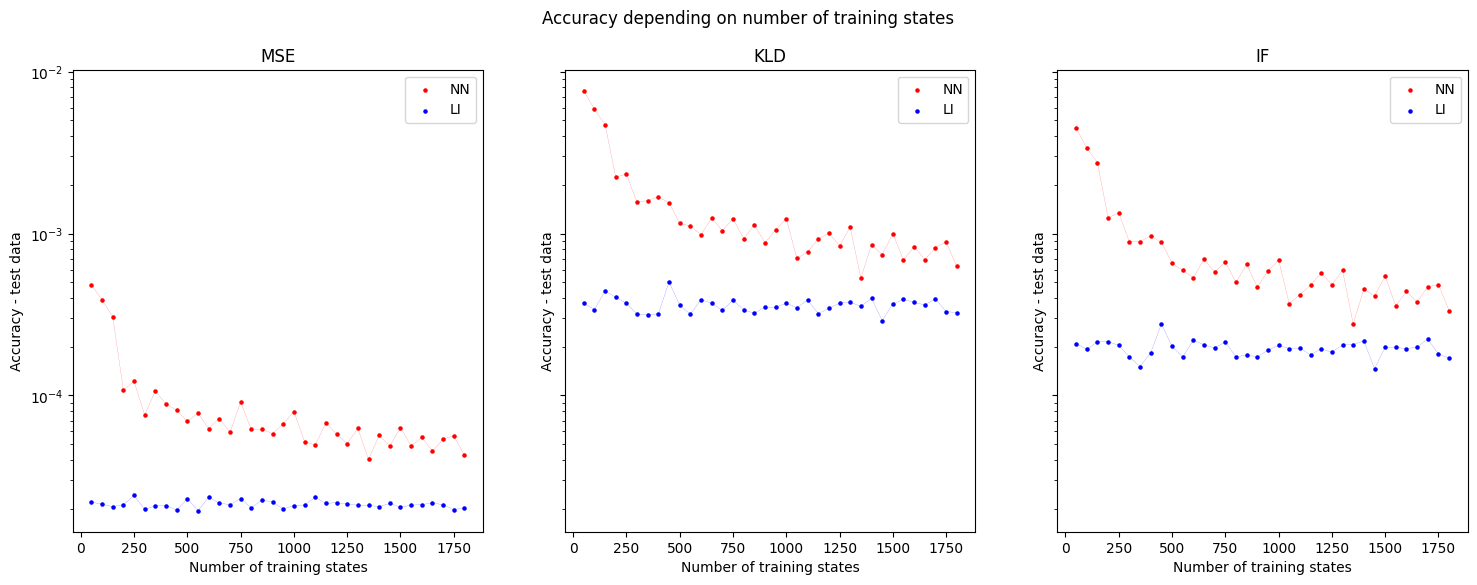

In [20]:
nQubit = 2
layers = [20,20,20,20,20,2**nQubit]
num_epochs = 300
batch_size = 50
learning_rate = 0.001
test_states = 500
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)


training_states = np.arange(50,1850,50)
accuracies = []

for numb in tqdm(training_states):
    training_data = np.zeros((numb,2**nQubit*2))

    calibration_states_list = []
    calibration_probs_list = []
    desired_probs_list = []
    test_probs_list = []
    desired_test_probs_list = []

    for i in range(numb):
        state = generate_random_seperable_pure_state(nQubit)
        calibration_states_list.append(state)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        calibration_probs_list.append(noisy_probs_sampled)
        desired_probs_list.append(probs)
        for j in range(2**nQubit):
            training_data[i][j] = noisy_probs_sampled[j]
            #training_data[i][j] = noisy_probs[j]
            training_data[i][j+2**nQubit] = probs[j]

    data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_training_input = []
    batched_training_target_outputs = []

    for batch in data_loader_training:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_training_input.append(inputs)
        batched_training_target_outputs.append(targets)

    for i in range(test_states):
        state = generate_random_seperable_pure_state(nQubit)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        test_probs_list.append(noisy_probs_sampled)
        desired_test_probs_list.append(probs)
        for j in range(2**nQubit):
            test_data[i][j] = noisy_probs_sampled[j]
            #test_data[i][j] = noisy_probs[j]
            test_data[i][j+2**nQubit] = probs[j]

    data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_test_input = []
    batched_test_target_outputs = []

    for batch in data_loader_test:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_test_input.append(inputs)
        batched_test_target_outputs.append(targets)

    batched_tr_inp = jnp.asarray(batched_training_input)
    batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
    batched_test_inp = jnp.asarray(batched_test_input)
    batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

    calibration_states = np.asarray(calibration_states_list)
    calibration_probs = np.asarray(calibration_probs_list)
    desired_probs = np.asarray(desired_probs_list)
    test_probs = np.asarray(test_probs_list)
    desired_test = np.asarray(desired_test_probs_list)

    L_inv2, POVM2, P2, MSE_data_LI2, KLD_data_LI2, IF_data_LI2 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
    trained_model_state2, MSE_data2, KLD_data2, IF_data2 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                                  batched_test_inp, batched_test_tar_out,
                                                                  nQubit=nQubit, num_epochs = num_epochs)

    accuracies.append([[MSE_data2,MSE_data_LI2],[KLD_data2,KLD_data_LI2],[IF_data2,IF_data_LI2]])

MSE_acc2 = []
MSE_acc_LI2 = []
KLD_acc2 = []
KLD_acc_LI2 = []
IF_acc2 = []
IF_acc_LI2 = []

for element in accuracies:
    MSE_acc2.append(element[0][0][0][-1])
    MSE_acc_LI2.append(element[0][1][0])
    KLD_acc2.append(element[1][0][0][-1])
    KLD_acc_LI2.append(element[1][1][0])
    IF_acc2.append(element[2][0][0][-1])
    IF_acc_LI2.append(element[2][1][0])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].scatter(training_states,MSE_acc2,s=5,label="NN",color="red")
axs[0].plot(training_states,MSE_acc2,color="red",linewidth=0.1)
axs[0].scatter(training_states,MSE_acc_LI2,s=5,label="LI",color="blue")
axs[0].plot(training_states,MSE_acc_LI2,color="blue",linewidth=0.1)
axs[0].set_xlabel('Number of training states')
axs[0].set_ylabel('Accuracy - test data')
axs[0].set_yscale('log')
axs[0].set_title('MSE')
axs[0].legend()
axs[1].scatter(training_states,KLD_acc2,s=5,label="NN",color="red")
axs[1].plot(training_states,KLD_acc2,color="red",linewidth=0.1)
axs[1].scatter(training_states,KLD_acc_LI2,s=5,label="LI",color="blue")
axs[1].plot(training_states,KLD_acc_LI2,color="blue",linewidth=0.1)
axs[1].set_xlabel('Number of training states')
axs[1].set_ylabel('Accuracy - test data')
axs[1].set_yscale('log')
axs[1].set_title('KLD')
axs[1].legend()
axs[2].scatter(training_states,IF_acc2,s=5,label="NN",color="red")
axs[2].plot(training_states,IF_acc2,color="red",linewidth=0.1)
axs[2].scatter(training_states,IF_acc_LI2,s=5,label="LI",color="blue")
axs[2].plot(training_states,IF_acc_LI2,color="blue",linewidth=0.1)
axs[2].set_xlabel('Number of training states')
axs[2].set_ylabel('Accuracy - test data')
axs[2].set_yscale('log')
axs[2].set_title('IF')
axs[2].legend()
fig.suptitle('Accuracy depending on number of training states')

In [ ]:
nQubit = 3
layers = [40,40,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
#training_states = 3800
test_states = 500
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

training_states = np.arange(100,4000,100)
accuracies = []

for numb in tqdm(training_states):
    training_data = np.zeros((numb,2**nQubit*2))

    calibration_states_list = []
    calibration_probs_list = []
    desired_probs_list = []
    test_probs_list = []
    desired_test_probs_list = []

    for i in range(numb):
        state = generate_random_seperable_pure_state(nQubit)
        calibration_states_list.append(state)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        calibration_probs_list.append(noisy_probs_sampled)
        desired_probs_list.append(probs)
        for j in range(2**nQubit):
            training_data[i][j] = noisy_probs_sampled[j]
            #training_data[i][j] = noisy_probs[j]
            training_data[i][j+2**nQubit] = probs[j]

    data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_training_input = []
    batched_training_target_outputs = []

    for batch in data_loader_training:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_training_input.append(inputs)
        batched_training_target_outputs.append(targets)

    for i in range(test_states):
        state = generate_random_seperable_pure_state(nQubit)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        test_probs_list.append(noisy_probs_sampled)
        desired_test_probs_list.append(probs)
        for j in range(2**nQubit):
            test_data[i][j] = noisy_probs_sampled[j]
            #test_data[i][j] = noisy_probs[j]
            test_data[i][j+2**nQubit] = probs[j]

    data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_test_input = []
    batched_test_target_outputs = []

    for batch in data_loader_test:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_test_input.append(inputs)
        batched_test_target_outputs.append(targets)

    batched_tr_inp = jnp.asarray(batched_training_input)
    batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
    batched_test_inp = jnp.asarray(batched_test_input)
    batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

    calibration_states = np.asarray(calibration_states_list)
    calibration_probs = np.asarray(calibration_probs_list)
    desired_probs = np.asarray(desired_probs_list)
    test_probs = np.asarray(test_probs_list)
    desired_test = np.asarray(desired_test_probs_list)

    L_inv3, POVM3, P3, MSE_data_LI3, KLD_data_LI3, IF_data_LI3 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
    trained_model_state3, MSE_data3, KLD_data3, IF_data3 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                                  batched_test_inp, batched_test_tar_out,
                                                                  nQubit=nQubit, num_epochs = num_epochs)

    accuracies.append([[MSE_data3,MSE_data_LI3],[KLD_data3,KLD_data_LI3],[IF_data3,IF_data_LI3]])

MSE_acc3 = []
MSE_acc_LI3 = []
KLD_acc3 = []
KLD_acc_LI3 = []
IF_acc3 = []
IF_acc_LI3 = []

for element in accuracies:
    MSE_acc3.append(element[0][0][0][-1])
    MSE_acc_LI3.append(element[0][1][0])
    KLD_acc3.append(element[1][0][0][-1])
    KLD_acc_LI3.append(element[1][1][0])
    IF_acc3.append(element[2][0][0][-1])
    IF_acc_LI3.append(element[2][1][0])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].scatter(training_states,MSE_acc3,s=5,label="NN",color="red")
axs[0].plot(training_states,MSE_acc3,color="red",linewidth=0.1)
axs[0].scatter(training_states,MSE_acc_LI3,s=5,label="LI",color="blue")
axs[0].plot(training_states,MSE_acc_LI3,color="blue",linewidth=0.1)
axs[0].set_xlabel('Number of training states')
axs[0].set_ylabel('Accuracy - test data')
axs[0].set_yscale('log')
axs[0].set_title('MSE')
axs[0].legend()
axs[1].scatter(training_states,KLD_acc3,s=5,label="NN",color="red")
axs[1].plot(training_states,KLD_acc3,color="red",linewidth=0.1)
axs[1].scatter(training_states,KLD_acc_LI3,s=5,label="LI",color="blue")
axs[1].plot(training_states,KLD_acc_LI3,color="blue",linewidth=0.1)
axs[1].set_xlabel('Number of training states')
axs[1].set_ylabel('Accuracy - test data')
axs[1].set_yscale('log')
axs[1].set_title('KLD')
axs[1].legend()
axs[2].scatter(training_states,IF_acc3,s=5,label="NN",color="red")
axs[2].plot(training_states,IF_acc3,color="red",linewidth=0.1)
axs[2].scatter(training_states,IF_acc_LI3,s=5,label="LI",color="blue")
axs[2].plot(training_states,IF_acc_LI3,color="blue",linewidth=0.1)
axs[2].set_xlabel('Number of training states')
axs[2].set_ylabel('Accuracy - test data')
axs[2].set_yscale('log')
axs[2].set_title('IF')
axs[2].legend()
fig.suptitle('Accuracy depending on number of training states')

  0%|          | 0/39 [00:00<?, ?it/s]

<ipython-input-23-9c506bb5fcbb>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]
<ipython-input-23-9c506bb5fcbb>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.018948622192669063
loop number: 50, distance: 0.0004426148629385124
loop number: 100, distance: 0.0002351523427900092
loop number: 150, distance: 0.0001563569058009209
loop number: 200, distance: 0.0001150470652084176
loop number: 250, distance: 8.922056794790705e-05
loop number: 300, distance: 7.140878982133442e-05
loop number: 350, distance: 5.841684034645849e-05
loop number: 400, distance: 4.860412016426641e-05
loop number: 450, distance: 4.1010902239907245e-05
loop number: 500, distance: 3.502507620541923e-05
loop number: 550, distance: 3.0233613927602515e-05
loop number: 600, distance: 2.634709766381509e-05
loop number: 650, distance: 2.3157224851323997e-05
loop number: 700, distance: 2.051099826299844e-05
loop number: 750, distance: 1.8294180481879507e-05
loop number: 800, distance: 1.642027203565892e-05
loop number: 850, distance: 1.482296056846446e-05
loop number: 900, distance: 1.3450836509090806e-05
loop number: 950, distance: 1.2263631248869661e-0

<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.011583251730491607
loop number: 50, distance: 0.0002807539793118284
loop number: 100, distance: 0.00013941659412348422
loop number: 150, distance: 8.291599998518846e-05
loop number: 200, distance: 5.350647731366968e-05
loop number: 250, distance: 3.630618643677519e-05
loop number: 300, distance: 2.5502481758468802e-05
loop number: 350, distance: 1.8374303830551522e-05
loop number: 400, distance: 1.3496788019553566e-05
loop number: 450, distance: 1.0064396644688439e-05
loop number: 500, distance: 7.59508905601414e-06
loop number: 550, distance: 5.7871345104384735e-06
loop number: 600, distance: 4.444538409424172e-06
loop number: 650, distance: 3.4359742324143214e-06
loop number: 700, distance: 2.671118372432701e-06
loop number: 750, distance: 2.0864728373179396e-06
loop number: 800, distance: 1.6365741197754203e-06
loop number: 850, distance: 1.2883706715374547e-06
loop number: 900, distance: 1.0175259128639594e-06
loop number: 950, distance: 8.05927060620556

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.010421633208216836
loop number: 50, distance: 0.0002561540037116043
loop number: 100, distance: 0.00010848646809727372
loop number: 150, distance: 5.6931909775617927e-05
loop number: 200, distance: 3.265947901763549e-05
loop number: 250, distance: 1.965183468180991e-05
loop number: 300, distance: 1.2191598793212238e-05
loop number: 350, distance: 7.729055454602084e-06
loop number: 400, distance: 4.980258970195697e-06
loop number: 450, distance: 3.249602441572157e-06
loop number: 500, distance: 2.1413124070528726e-06
loop number: 550, distance: 1.421997222630876e-06
loop number: 600, distance: 9.501326467611893e-07
loop number: 650, distance: 6.37949688631171e-07
loop number: 700, distance: 4.3000490752824656e-07
loop number: 750, distance: 2.9074073147994906e-07
loop number: 800, distance: 1.9706846017471185e-07
loop number: 850, distance: 1.338434918573996e-07
loop number: 900, distance: 9.105018108303594e-08
loop number: 950, distance: 6.202074373479467e-0

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006450316685320607
loop number: 50, distance: 0.0001869256210920547
loop number: 100, distance: 7.584017212726331e-05
loop number: 150, distance: 3.69233128351989e-05
loop number: 200, distance: 1.921089282683132e-05
loop number: 250, distance: 1.0353036437968417e-05
loop number: 300, distance: 5.706867829837056e-06
loop number: 350, distance: 3.1961158314629032e-06
loop number: 400, distance: 1.8110575338096054e-06
loop number: 450, distance: 1.0354258001788392e-06
loop number: 500, distance: 5.9613234375598e-07
loop number: 550, distance: 3.451447869629646e-07
loop number: 600, distance: 2.0074822053572155e-07
loop number: 650, distance: 1.1720859251665466e-07
loop number: 700, distance: 6.865410792717328e-08
loop number: 750, distance: 4.032459261510597e-08
loop number: 800, distance: 2.37414716118044e-08
loop number: 850, distance: 1.4007100067040631e-08
loop number: 900, distance: 8.279128808707842e-09
loop number: 950, distance: 4.9014974946453324e-09


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006970382951175706
loop number: 50, distance: 0.00016270719082793456
loop number: 100, distance: 6.566895468682345e-05
loop number: 150, distance: 3.100134579514462e-05
loop number: 200, distance: 1.5547772523759835e-05
loop number: 250, distance: 8.096215710189784e-06
loop number: 300, distance: 4.334016373402306e-06
loop number: 350, distance: 2.370780176290303e-06
loop number: 400, distance: 1.3195749322530595e-06
loop number: 450, distance: 7.448578661586699e-07
loop number: 500, distance: 4.252391767565545e-07
loop number: 550, distance: 2.449904417094027e-07
loop number: 600, distance: 1.4217892787376088e-07
loop number: 650, distance: 8.299615016644983e-08
loop number: 700, distance: 4.8675565913381225e-08
loop number: 750, distance: 2.8654473355452567e-08
loop number: 800, distance: 1.6919366618402914e-08
loop number: 850, distance: 1.0014618666817494e-08
loop number: 900, distance: 5.939423945621047e-09
loop number: 950, distance: 3.528220191730299e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00796788545639521
loop number: 50, distance: 0.00014780000200918653
loop number: 100, distance: 5.7971164573252796e-05
loop number: 150, distance: 2.622766471711256e-05
loop number: 200, distance: 1.2609946784019536e-05
loop number: 250, distance: 6.2752525568214756e-06
loop number: 300, distance: 3.1933361892566907e-06
loop number: 350, distance: 1.6510910452695987e-06
loop number: 400, distance: 8.64123801446618e-07
loop number: 450, distance: 4.5667478711285467e-07
loop number: 500, distance: 2.4329552151631816e-07
loop number: 550, distance: 1.305032253047911e-07
loop number: 600, distance: 7.041384345819968e-08
loop number: 650, distance: 3.818739542315285e-08
loop number: 700, distance: 2.0803852754154307e-08
loop number: 750, distance: 1.137917032790746e-08
loop number: 800, distance: 6.246480619462172e-09
loop number: 850, distance: 3.440000812662032e-09
loop number: 900, distance: 1.899943437577287e-09
loop number: 950, distance: 1.0521031847222645e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00557377383781537
loop number: 50, distance: 0.0001282668858096256
loop number: 100, distance: 4.892962393475196e-05
loop number: 150, distance: 2.1934466679535155e-05
loop number: 200, distance: 1.0364206280863014e-05
loop number: 250, distance: 5.025092038648096e-06
loop number: 300, distance: 2.4757469482657667e-06
loop number: 350, distance: 1.2336259657152217e-06
loop number: 400, distance: 6.200015305197067e-07
loop number: 450, distance: 3.1373192480039106e-07
loop number: 500, distance: 1.5963647159873308e-07
loop number: 550, distance: 8.160256062379941e-08
loop number: 600, distance: 4.187535527964192e-08
loop number: 650, distance: 2.1559957234595316e-08
loop number: 700, distance: 1.113199833867278e-08
loop number: 750, distance: 5.76199844487537e-09
loop number: 800, distance: 2.988934766486734e-09
loop number: 850, distance: 1.553441017701613e-09
final loop number: 885, final distance: 9.964481875472178e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006272594050305511
loop number: 50, distance: 0.0001323864146879633
loop number: 100, distance: 5.1766391822476454e-05
loop number: 150, distance: 2.267191444186358e-05
loop number: 200, distance: 1.0393681388683985e-05
loop number: 250, distance: 4.893331173884379e-06
loop number: 300, distance: 2.3452142489261382e-06
loop number: 350, distance: 1.1389140397348182e-06
loop number: 400, distance: 5.589385642700631e-07
loop number: 450, distance: 2.767362705985635e-07
loop number: 500, distance: 1.3806758901811166e-07
loop number: 550, distance: 6.935301007179324e-08
loop number: 600, distance: 3.504995494268831e-08
loop number: 650, distance: 1.7811754730044435e-08
loop number: 700, distance: 9.097119184180191e-09
loop number: 750, distance: 4.667490255434111e-09
loop number: 800, distance: 2.4047428134255923e-09
loop number: 850, distance: 1.243651919115473e-09
final loop number: 868, final distance: 9.946753094623793e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005317478534153826
loop number: 50, distance: 0.0001057083290508466
loop number: 100, distance: 3.769463866857896e-05
loop number: 150, distance: 1.5997811975209793e-05
loop number: 200, distance: 7.1287312248301615e-06
loop number: 250, distance: 3.2459335899757895e-06
loop number: 300, distance: 1.4980995867402205e-06
loop number: 350, distance: 6.986055504923092e-07
loop number: 400, distance: 3.286248838346417e-07
loop number: 450, distance: 1.5576972510352996e-07
loop number: 500, distance: 7.434027933065193e-08
loop number: 550, distance: 3.5696118338723296e-08
loop number: 600, distance: 1.723461868611717e-08
loop number: 650, distance: 8.362134822746994e-09
loop number: 700, distance: 4.075098491652542e-09
loop number: 750, distance: 1.9936737624564547e-09
final loop number: 800, final distance: 9.927483278254922e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005177603672512278
loop number: 50, distance: 0.00010682975800637929
loop number: 100, distance: 3.8221160300516315e-05
loop number: 150, distance: 1.5783229446280783e-05
loop number: 200, distance: 6.824755810533671e-06
loop number: 250, distance: 3.0203759190087273e-06
loop number: 300, distance: 1.357212405995889e-06
loop number: 350, distance: 6.168221922536327e-07
loop number: 400, distance: 2.8286109701528544e-07
loop number: 450, distance: 1.306701516851974e-07
loop number: 500, distance: 6.073467376652391e-08
loop number: 550, distance: 2.837515606657702e-08
loop number: 600, distance: 1.3315257844884329e-08
loop number: 650, distance: 6.271967140548142e-09
loop number: 700, distance: 2.964043154208462e-09
loop number: 750, distance: 1.4048077898417898e-09
final loop number: 774, final distance: 9.973187214923921e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005529180196308932
loop number: 50, distance: 0.00010464086658250397
loop number: 100, distance: 3.689455673783112e-05
loop number: 150, distance: 1.528961522201594e-05
loop number: 200, distance: 6.609162803305713e-06
loop number: 250, distance: 2.914512644864214e-06
loop number: 300, distance: 1.302403661593086e-06
loop number: 350, distance: 5.88059633333904e-07
loop number: 400, distance: 2.6784811966185393e-07
loop number: 450, distance: 1.2293447006227523e-07
loop number: 500, distance: 5.6808452331792864e-08
loop number: 550, distance: 2.6412095090232543e-08
loop number: 600, distance: 1.2347463412723122e-08
loop number: 650, distance: 5.80095799368721e-09
loop number: 700, distance: 2.737496561427809e-09
loop number: 750, distance: 1.2970144748367034e-09
final loop number: 769, final distance: 9.9208377047918e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004801361339156705
loop number: 50, distance: 0.00010219527558314484
loop number: 100, distance: 3.806149710559935e-05
loop number: 150, distance: 1.6321660602089512e-05
loop number: 200, distance: 7.278525719652281e-06
loop number: 250, distance: 3.309843005342965e-06
loop number: 300, distance: 1.5251702345623664e-06
loop number: 350, distance: 7.100824624166831e-07
loop number: 400, distance: 3.334744160199154e-07
loop number: 450, distance: 1.578028236574212e-07
loop number: 500, distance: 7.518394370586008e-08
loop number: 550, distance: 3.6042642184745905e-08
loop number: 600, distance: 1.7375846792976572e-08
loop number: 650, distance: 8.419555831107893e-09
loop number: 700, distance: 4.0985979564247135e-09
loop number: 750, distance: 2.003479530218348e-09
final loop number: 800, final distance: 9.970563211099422e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004899601008142942
loop number: 50, distance: 8.795441698977723e-05
loop number: 100, distance: 2.89188588376648e-05
loop number: 150, distance: 1.1491921752202708e-05
loop number: 200, distance: 4.826192290154776e-06
loop number: 250, distance: 2.0813798715101244e-06
loop number: 300, distance: 9.13467737322596e-07
loop number: 350, distance: 4.0631269820340055e-07
loop number: 400, distance: 1.8272282195770826e-07
loop number: 450, distance: 8.293328010778181e-08
loop number: 500, distance: 3.793754660900138e-08
loop number: 550, distance: 1.747120170029213e-08
loop number: 600, distance: 8.092439728039147e-09
loop number: 650, distance: 3.7669898513384196e-09
loop number: 700, distance: 1.7610675952820782e-09
final loop number: 739, final distance: 9.906158111001028e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00503246042242451
loop number: 50, distance: 7.258611443791903e-05
loop number: 100, distance: 2.4498871166136308e-05
loop number: 150, distance: 1.0098570535753223e-05
loop number: 200, distance: 4.405335877170037e-06
loop number: 250, distance: 1.9766579332651508e-06
loop number: 300, distance: 9.033712339928432e-07
loop number: 350, distance: 4.183920449863691e-07
loop number: 400, distance: 1.9574914495165598e-07
loop number: 450, distance: 9.231388640594533e-08
loop number: 500, distance: 4.381291967804696e-08
loop number: 550, distance: 2.0902460147262037e-08
loop number: 600, distance: 1.0015319868156236e-08
loop number: 650, distance: 4.816170354015524e-09
loop number: 700, distance: 2.3231009172552054e-09
loop number: 750, distance: 1.123490614931619e-09
final loop number: 760, final distance: 9.860246561167398e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0034513958945493945
loop number: 50, distance: 8.150281874730003e-05
loop number: 100, distance: 2.8443346463380753e-05
loop number: 150, distance: 1.1607038790818694e-05
loop number: 200, distance: 4.966940230808068e-06
loop number: 250, distance: 2.1769142047899782e-06
loop number: 300, distance: 9.704630646956685e-07
loop number: 350, distance: 4.386941291854175e-07
loop number: 400, distance: 2.00689797481801e-07
loop number: 450, distance: 9.276247920281726e-08
loop number: 500, distance: 4.3259820751584305e-08
loop number: 550, distance: 2.0328334166148106e-08
loop number: 600, distance: 9.614351487395263e-09
loop number: 650, distance: 4.571893012710885e-09
loop number: 700, distance: 2.183973750285122e-09
loop number: 750, distance: 1.0472470783232667e-09
final loop number: 755, final distance: 9.875902067034197e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004825354357240015
loop number: 50, distance: 7.997232391180303e-05
loop number: 100, distance: 2.7624519191833608e-05
loop number: 150, distance: 1.1346974755919123e-05
loop number: 200, distance: 4.8935872262336634e-06
loop number: 250, distance: 2.155960629811846e-06
loop number: 300, distance: 9.625446171810358e-07
loop number: 350, distance: 4.339830880588653e-07
loop number: 400, distance: 1.9720640736743794e-07
loop number: 450, distance: 9.01890272683419e-08
loop number: 500, distance: 4.146762746745855e-08
loop number: 550, distance: 1.9152584001872584e-08
loop number: 600, distance: 8.880194809989283e-09
loop number: 650, distance: 4.131093053064103e-09
loop number: 700, distance: 1.9273845112183966e-09
final loop number: 745, final distance: 9.874715167361073e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00399000466022781
loop number: 50, distance: 8.05713951027655e-05
loop number: 100, distance: 2.91201708843907e-05
loop number: 150, distance: 1.2167099393465167e-05
loop number: 200, distance: 5.269001926795084e-06
loop number: 250, distance: 2.322520741801863e-06
loop number: 300, distance: 1.036412915358882e-06
loop number: 350, distance: 4.6695499879077456e-07
loop number: 400, distance: 2.12048997178935e-07
loop number: 450, distance: 9.693535108114874e-08
loop number: 500, distance: 4.456642807608389e-08
loop number: 550, distance: 2.0591683382336827e-08
loop number: 600, distance: 9.555881071939322e-09
loop number: 650, distance: 4.451670983589154e-09
loop number: 700, distance: 2.0809428313892023e-09
final loop number: 750, final distance: 9.905725617168496e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003945995527193416
loop number: 50, distance: 7.868267442210667e-05
loop number: 100, distance: 2.7387943509377232e-05
loop number: 150, distance: 1.1258816180980495e-05
loop number: 200, distance: 4.852080131145953e-06
loop number: 250, distance: 2.1345204051252036e-06
loop number: 300, distance: 9.50421842220947e-07
loop number: 350, distance: 4.267216404103688e-07
loop number: 400, distance: 1.927925495354158e-07
loop number: 450, distance: 8.753683882618704e-08
loop number: 500, distance: 3.9908063382479924e-08
loop number: 550, distance: 1.8256559517818122e-08
loop number: 600, distance: 8.376319827334529e-09
loop number: 650, distance: 3.852992083451589e-09
loop number: 700, distance: 1.776322385229196e-09
final loop number: 739, final distance: 9.875074064136181e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003990061714421428
loop number: 50, distance: 7.617779814618489e-05
loop number: 100, distance: 2.6255534947676602e-05
loop number: 150, distance: 1.0441347277547868e-05
loop number: 200, distance: 4.330791751847115e-06
loop number: 250, distance: 1.8351851023176843e-06
loop number: 300, distance: 7.893943959295346e-07
loop number: 350, distance: 3.4364018706755185e-07
loop number: 400, distance: 1.511057128503984e-07
loop number: 450, distance: 6.701859838945029e-08
loop number: 500, distance: 2.994529679213937e-08
loop number: 550, distance: 1.3466088321367187e-08
loop number: 600, distance: 6.0892061204574995e-09
loop number: 650, distance: 2.7667559360086796e-09
loop number: 700, distance: 1.262428960499633e-09
final loop number: 716, final distance: 9.983896547202315e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004025149401934366
loop number: 50, distance: 6.800116903558651e-05
loop number: 100, distance: 2.355235419087006e-05
loop number: 150, distance: 9.564933093013368e-06
loop number: 200, distance: 4.036730392502466e-06
loop number: 250, distance: 1.7350882257309705e-06
loop number: 300, distance: 7.549086944934066e-07
loop number: 350, distance: 3.3153942143705273e-07
loop number: 400, distance: 1.467422181487549e-07
loop number: 450, distance: 6.538807092420295e-08
loop number: 500, distance: 2.9310675330139375e-08
loop number: 550, distance: 1.3208735082115979e-08
loop number: 600, distance: 5.980931574766078e-09
loop number: 650, distance: 2.7198245188884137e-09
loop number: 700, distance: 1.241629758233458e-09
final loop number: 715, final distance: 9.97508103635706e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003828880450181655
loop number: 50, distance: 6.88249936999958e-05
loop number: 100, distance: 2.4803999854542523e-05
loop number: 150, distance: 1.0128047930719149e-05
loop number: 200, distance: 4.2636989561975674e-06
loop number: 250, distance: 1.8227520584968853e-06
loop number: 300, distance: 7.87643948868963e-07
loop number: 350, distance: 3.4326285208937763e-07
loop number: 400, distance: 1.5066196790704776e-07
loop number: 450, distance: 6.652687665919002e-08
loop number: 500, distance: 2.952746590509739e-08
loop number: 550, distance: 1.3163328125302241e-08
loop number: 600, distance: 5.8902745804163435e-09
loop number: 650, distance: 2.64420176156124e-09
loop number: 700, distance: 1.1902447528307395e-09
final loop number: 712, final distance: 9.98877757953532e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0034896745153541824
loop number: 50, distance: 6.565801124632286e-05
loop number: 100, distance: 2.3603804520657793e-05
loop number: 150, distance: 9.73574931382857e-06
loop number: 200, distance: 4.140175279352317e-06
loop number: 250, distance: 1.7846094203149289e-06
loop number: 300, distance: 7.761197902923626e-07
loop number: 350, distance: 3.398640890976077e-07
loop number: 400, distance: 1.4968443469698746e-07
loop number: 450, distance: 6.625343755101238e-08
loop number: 500, distance: 2.945433118714556e-08
loop number: 550, distance: 1.3146073545838931e-08
loop number: 600, distance: 5.888142078938494e-09
loop number: 650, distance: 2.6457464031490687e-09
loop number: 700, distance: 1.1922758901577138e-09
final loop number: 713, final distance: 9.850766586069061e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003588754140723318
loop number: 50, distance: 7.422817373514026e-05
loop number: 100, distance: 2.5768579634599058e-05
loop number: 150, distance: 1.0145202727499766e-05
loop number: 200, distance: 4.138050449886372e-06
loop number: 250, distance: 1.7148448871521076e-06
loop number: 300, distance: 7.178903956791845e-07
loop number: 350, distance: 3.028762735110243e-07
loop number: 400, distance: 1.2860771601257474e-07
loop number: 450, distance: 5.4911279585169e-08
loop number: 500, distance: 2.355783638545241e-08
loop number: 550, distance: 1.0149154170623316e-08
loop number: 600, distance: 4.388596712938399e-09
loop number: 650, distance: 1.9038619524913525e-09
final loop number: 690, final distance: 9.94519512168335e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0036209243219063824
loop number: 50, distance: 6.426913550505293e-05
loop number: 100, distance: 2.30185038888661e-05
loop number: 150, distance: 9.337872258295732e-06
loop number: 200, distance: 3.918684710567287e-06
loop number: 250, distance: 1.6730104918505252e-06
loop number: 300, distance: 7.222168412604267e-07
loop number: 350, distance: 3.1424277842536714e-07
loop number: 400, distance: 1.375480022767176e-07
loop number: 450, distance: 6.048981209974382e-08
loop number: 500, distance: 2.670314547990474e-08
loop number: 550, distance: 1.182527835705826e-08
loop number: 600, distance: 5.250659737312226e-09
loop number: 650, distance: 2.3366957154023668e-09
loop number: 700, distance: 1.041939331459529e-09
final loop number: 704, final distance: 9.927079958242708e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0037773835554810067
loop number: 50, distance: 6.270134704894187e-05
loop number: 100, distance: 2.2103871819424692e-05
loop number: 150, distance: 8.90950348555108e-06
loop number: 200, distance: 3.6959099256942824e-06
loop number: 250, distance: 1.5537672885380103e-06
loop number: 300, distance: 6.59255572494657e-07
loop number: 350, distance: 2.8181258935178006e-07
loop number: 400, distance: 1.212450716580311e-07
loop number: 450, distance: 5.246309786194684e-08
loop number: 500, distance: 2.281821092018446e-08
loop number: 550, distance: 9.970884398211946e-09
loop number: 600, distance: 4.375420038317974e-09
loop number: 650, distance: 1.92737707006148e-09
final loop number: 692, final distance: 9.865768839487746e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003406714140338938
loop number: 50, distance: 5.690602090880339e-05
loop number: 100, distance: 1.9826588037632774e-05
loop number: 150, distance: 7.997082509452102e-06
loop number: 200, distance: 3.347546546341435e-06
loop number: 250, distance: 1.4273765729327377e-06
loop number: 300, distance: 6.159293679310546e-07
loop number: 350, distance: 2.6806938204279727e-07
loop number: 400, distance: 1.1743991660564817e-07
loop number: 450, distance: 5.1721207890494684e-08
loop number: 500, distance: 2.2877645843611028e-08
loop number: 550, distance: 1.0156731282027585e-08
loop number: 600, distance: 4.523491382033588e-09
loop number: 650, distance: 2.0201943149204096e-09
final loop number: 695, final distance: 9.958604869654214e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0029515075740636286
loop number: 50, distance: 5.895325204372099e-05
loop number: 100, distance: 2.1041910172541282e-05
loop number: 150, distance: 8.554480020187129e-06
loop number: 200, distance: 3.5885841955065657e-06
loop number: 250, distance: 1.5267272019503966e-06
loop number: 300, distance: 6.552603342794246e-07
loop number: 350, distance: 2.830203649678034e-07
loop number: 400, distance: 1.228440629533689e-07
loop number: 450, distance: 5.3531612075897297e-08
loop number: 500, distance: 2.3403725676012956e-08
loop number: 550, distance: 1.0259975374488585e-08
loop number: 600, distance: 4.508270464830933e-09
loop number: 650, distance: 1.98484711884569e-09
final loop number: 693, final distance: 9.977449436055184e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0026776738268444447
loop number: 50, distance: 5.6292176497766315e-05
loop number: 100, distance: 1.9238679320523632e-05
loop number: 150, distance: 7.859937858157766e-06
loop number: 200, distance: 3.3344189152720614e-06
loop number: 250, distance: 1.4354565591423199e-06
loop number: 300, distance: 6.231487674913465e-07
loop number: 350, distance: 2.7205836186365973e-07
loop number: 400, distance: 1.1928410621197252e-07
loop number: 450, distance: 5.247821428684205e-08
loop number: 500, distance: 2.3152753797541338e-08
loop number: 550, distance: 1.0239417735856237e-08
loop number: 600, distance: 4.537975445023547e-09
loop number: 650, distance: 2.014918824801018e-09
final loop number: 695, final distance: 9.875655255464936e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002963949552418051
loop number: 50, distance: 5.60886540309989e-05
loop number: 100, distance: 1.8847080808033497e-05
loop number: 150, distance: 7.458081698558701e-06
loop number: 200, distance: 3.0753652623128946e-06
loop number: 250, distance: 1.290536133023584e-06
loop number: 300, distance: 5.472409952552794e-07
loop number: 350, distance: 2.3378750882959756e-07
loop number: 400, distance: 1.0046185550437206e-07
loop number: 450, distance: 4.3378944968534724e-08
loop number: 500, distance: 1.880807873802779e-08
loop number: 550, distance: 8.183910785827513e-09
loop number: 600, distance: 3.572218846229225e-09
loop number: 650, distance: 1.5635722298449707e-09
final loop number: 679, final distance: 9.854912647570412e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0027865786306648216
loop number: 50, distance: 5.6501508083162016e-05
loop number: 100, distance: 2.0569615313116298e-05
loop number: 150, distance: 8.293106126212063e-06
loop number: 200, distance: 3.4212458882805957e-06
loop number: 250, distance: 1.4260894337574043e-06
loop number: 300, distance: 5.983365577973741e-07
loop number: 350, distance: 2.522559282062231e-07
loop number: 400, distance: 1.0676671572125809e-07
loop number: 450, distance: 4.5340760991712566e-08
loop number: 500, distance: 1.9312676280163838e-08
loop number: 550, distance: 8.248705817195777e-09
loop number: 600, distance: 3.5321229989693087e-09
loop number: 650, distance: 1.516098530969518e-09
final loop number: 676, final distance: 9.94138251047944e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00345736555634088
loop number: 50, distance: 5.7745980188716966e-05
loop number: 100, distance: 2.0273747891229077e-05
loop number: 150, distance: 8.10028285779429e-06
loop number: 200, distance: 3.3234574085232776e-06
loop number: 250, distance: 1.3794914262690985e-06
loop number: 300, distance: 5.771157085012665e-07
loop number: 350, distance: 2.429584935361408e-07
loop number: 400, distance: 1.0282976494410503e-07
loop number: 450, distance: 4.372550878593179e-08
loop number: 500, distance: 1.867041914465337e-08
loop number: 550, distance: 8.001801828098309e-09
loop number: 600, distance: 3.440906557778928e-09
loop number: 650, distance: 1.4841081008661894e-09
final loop number: 675, final distance: 9.921845375023856e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002765031292916839
loop number: 50, distance: 5.685098802569528e-05
loop number: 100, distance: 1.9778955700346805e-05
loop number: 150, distance: 7.869346571510906e-06
loop number: 200, distance: 3.2260645764336793e-06
loop number: 250, distance: 1.3399225641381921e-06
loop number: 300, distance: 5.612641255061479e-07
loop number: 350, distance: 2.3662309869047683e-07
loop number: 400, distance: 1.0028672161631255e-07
loop number: 450, distance: 4.269608349638089e-08
loop number: 500, distance: 1.824909925432471e-08
loop number: 550, distance: 7.827207942191523e-09
loop number: 600, distance: 3.367615233809891e-09
loop number: 650, distance: 1.4529527149525395e-09
final loop number: 674, final distance: 9.8785558897259e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0027791361992132156
loop number: 50, distance: 5.0454767243022934e-05
loop number: 100, distance: 1.6751051039114462e-05
loop number: 150, distance: 6.571943836666203e-06
loop number: 200, distance: 2.682604738386484e-06
loop number: 250, distance: 1.1137211006497758e-06
loop number: 300, distance: 4.675527605725724e-07
loop number: 350, distance: 1.980122609348897e-07
loop number: 400, distance: 8.448119115386697e-08
loop number: 450, distance: 3.627486504196233e-08
loop number: 500, distance: 1.5663668120537636e-08
loop number: 550, distance: 6.797461674708554e-09
loop number: 600, distance: 2.9630016962550646e-09
loop number: 650, distance: 1.2967212893310853e-09
final loop number: 667, final distance: 9.961846237208332e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002824154856220332
loop number: 50, distance: 5.938115484366039e-05
loop number: 100, distance: 2.0273977362634015e-05
loop number: 150, distance: 7.896998197972368e-06
loop number: 200, distance: 3.204816239439538e-06
loop number: 250, distance: 1.3244425768966424e-06
loop number: 300, distance: 5.53375874407272e-07
loop number: 350, distance: 2.3310828138815135e-07
loop number: 400, distance: 9.886847469487704e-08
loop number: 450, distance: 4.2184089407661586e-08
loop number: 500, distance: 1.8094253526284606e-08
loop number: 550, distance: 7.797978859175025e-09
loop number: 600, distance: 3.3747746413947017e-09
loop number: 650, distance: 1.465955321634918e-09
final loop number: 675, final distance: 9.835985667940298e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0035472043576362635
loop number: 50, distance: 5.5754115981043734e-05
loop number: 100, distance: 2.004449787612162e-05
loop number: 150, distance: 7.901658712965414e-06
loop number: 200, distance: 3.1973713751957393e-06
loop number: 250, distance: 1.3111322844958353e-06
loop number: 300, distance: 5.423921803359275e-07
loop number: 350, distance: 2.2584893673672478e-07
loop number: 400, distance: 9.453094196381163e-08
loop number: 450, distance: 3.973639485028459e-08
loop number: 500, distance: 1.676411569194745e-08
loop number: 550, distance: 7.0948134124292854e-09
loop number: 600, distance: 3.0109829333526944e-09
loop number: 650, distance: 1.2810194325744885e-09
final loop number: 666, final distance: 9.917559006225035e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002587394645681381
loop number: 50, distance: 5.263966988050081e-05
loop number: 100, distance: 1.7975186273699895e-05
loop number: 150, distance: 6.943094985338112e-06
loop number: 200, distance: 2.7716565374166782e-06
loop number: 250, distance: 1.1234126598389395e-06
loop number: 300, distance: 4.5966697213964827e-07
loop number: 350, distance: 1.8938737307630618e-07
loop number: 400, distance: 7.846962369264753e-08
loop number: 450, distance: 3.2672121146653344e-08
loop number: 500, distance: 1.3664074501528567e-08
loop number: 550, distance: 5.7381833609501255e-09
loop number: 600, distance: 2.419124713394745e-09
loop number: 650, distance: 1.0236442101310119e-09
final loop number: 653, final distance: 9.891018863169613e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0028421545667326655
loop number: 50, distance: 5.134925422615417e-05
loop number: 100, distance: 1.6983792968649697e-05
loop number: 150, distance: 6.684900224433694e-06
loop number: 200, distance: 2.7411137470993357e-06
loop number: 250, distance: 1.1424987395252297e-06
loop number: 300, distance: 4.809051636429727e-07
loop number: 350, distance: 2.0389715891796013e-07
loop number: 400, distance: 8.695699808034458e-08
loop number: 450, distance: 3.726869539996632e-08
loop number: 500, distance: 1.6041297175744252e-08
loop number: 550, distance: 6.930441695529335e-09
loop number: 600, distance: 3.0041344018605817e-09
loop number: 650, distance: 1.3060372553295784e-09
final loop number: 668, final distance: 9.84513467549271e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0027603820060963396
loop number: 50, distance: 5.3274608768624275e-05
loop number: 100, distance: 1.8415969605119422e-05
loop number: 150, distance: 7.270126879160285e-06
loop number: 200, distance: 2.9656181826860007e-06
loop number: 250, distance: 1.2269148881242393e-06
loop number: 300, distance: 5.121640007658002e-07
loop number: 350, distance: 2.152728924367787e-07
loop number: 400, distance: 9.100441139449224e-08
loop number: 450, distance: 3.8663803028805865e-08
loop number: 500, distance: 1.6499594848842605e-08
loop number: 550, distance: 7.069216416729278e-09
loop number: 600, distance: 3.0396956356570555e-09
loop number: 650, distance: 1.3113020173187696e-09
final loop number: 668, final distance: 9.859573804121836e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0024216753947581045
loop number: 50, distance: 4.892701635672529e-05
loop number: 100, distance: 1.744519667240073e-05
loop number: 150, distance: 7.01855178510809e-06
loop number: 200, distance: 2.9005566221915754e-06
loop number: 250, distance: 1.212269063916797e-06
loop number: 300, distance: 5.101179505298168e-07
loop number: 350, distance: 2.1570683304611546e-07
loop number: 400, distance: 9.15664923068861e-08
loop number: 450, distance: 3.8996354906997746e-08
loop number: 500, distance: 1.6655303922534853e-08
loop number: 550, distance: 7.131789429019087e-09
loop number: 600, distance: 3.0610258013225365e-09
loop number: 650, distance: 1.3166826877368957e-09
final loop number: 668, final distance: 9.8881126918353e-10


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/7800 [00:00<?, ?it/s]

<ipython-input-24-aee792287b76>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-24-aee792287b76>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.005494938148031074
loop number: 50, distance: 0.00016174750696816708
loop number: 100, distance: 8.62667696055117e-05
loop number: 150, distance: 5.502674881173074e-05
loop number: 200, distance: 3.744765664748947e-05
loop number: 250, distance: 2.6276591986787397e-05
loop number: 300, distance: 1.876723446767812e-05
loop number: 350, distance: 1.3559580132417408e-05
loop number: 400, distance: 9.877356128604298e-06
loop number: 450, distance: 7.239487535882922e-06
loop number: 500, distance: 5.331976992894935e-06
loop number: 550, distance: 3.942778825244313e-06
loop number: 600, distance: 2.9253503245520704e-06
loop number: 650, distance: 2.176755550844572e-06
loop number: 700, distance: 1.623818091322861e-06
loop number: 750, distance: 1.214036540853556e-06
loop number: 800, distance: 9.094654760763952e-07
loop number: 850, distance: 6.825136510774266e-07
loop number: 900, distance: 5.130162676204237e-07
loop number: 950, distance: 3.861716058625984e-07
l

<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

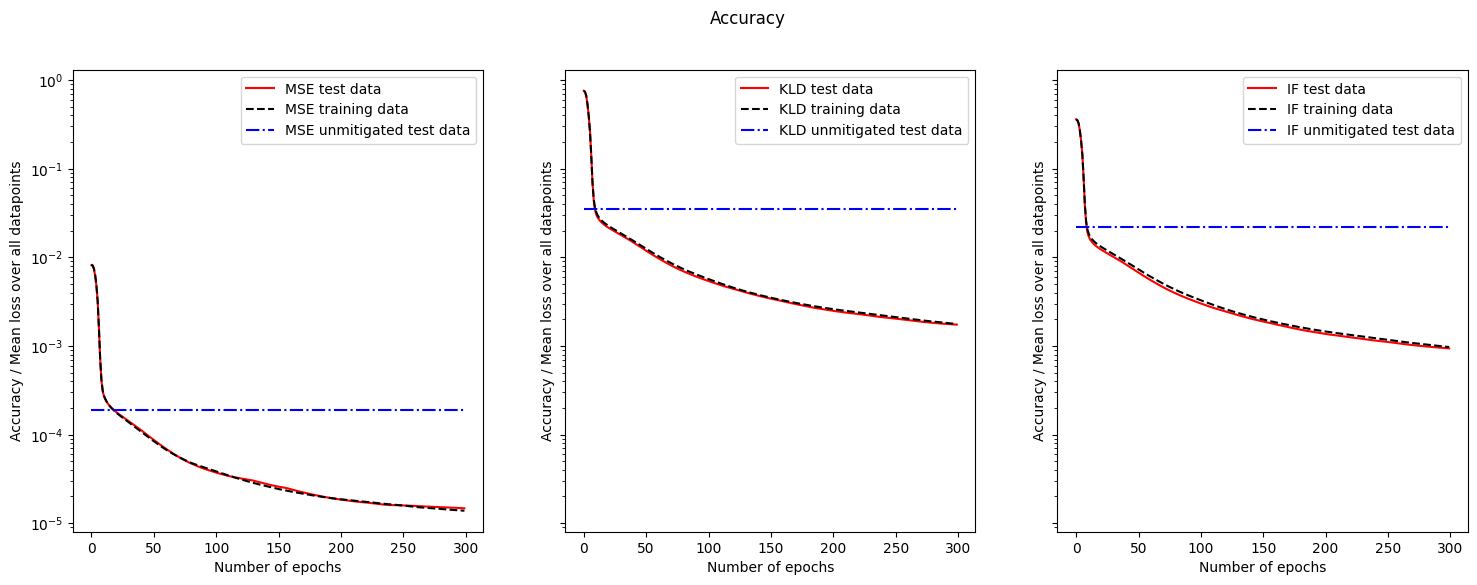

In [ ]:
nQubit = 4
layers = [80,80,80,80,80,80,80,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 5*10**-5
training_states = 7800
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

L_inv4, POVM4, P4, MSE_data_LI4, KLD_data_LI4, IF_data_LI4 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state4, MSE_data4, KLD_data4, IF_data4 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data4[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data4[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data4[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data4[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data4[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data4[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data4[0],label="IF test data",color="red")
axs[2].plot(i,IF_data4[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data4[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

In [ ]:
print(MSE_data_LI4, KLD_data_LI4, IF_data_LI4)
#print(POVM2)
for element in POVM4:
  print(np.all(np.linalg.eigvals(element) > 0))

[Array(7.4726363e-06, dtype=float32), Array(7.260887e-06, dtype=float32)] [Array(0.0016149-0.00102294j, dtype=complex64), Array(0.00164527-0.00103369j, dtype=complex64)] [Array(0.00098055-0.00057423j, dtype=complex64), Array(0.00096284-0.00058779j, dtype=complex64)]
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


  0%|          | 0/9900 [00:00<?, ?it/s]

<ipython-input-26-a2356db3f9db>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-26-a2356db3f9db>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.012631193392009552
loop number: 50, distance: 0.0004645921245399286
loop number: 100, distance: 0.00028334822688809484
loop number: 150, distance: 0.00019918592076357308
loop number: 200, distance: 0.0001498629231016861
loop number: 250, distance: 0.00011790984179330123
loop number: 300, distance: 9.569247094764779e-05
loop number: 350, distance: 7.939443708659002e-05
loop number: 400, distance: 6.695147776380189e-05
loop number: 450, distance: 5.716585747761442e-05
loop number: 500, distance: 4.929658961703109e-05
loop number: 550, distance: 4.285890500696958e-05
loop number: 600, distance: 3.752045278994947e-05
loop number: 650, distance: 3.3044476063634536e-05
loop number: 700, distance: 2.925699664102602e-05
loop number: 750, distance: 2.602691144204345e-05
loop number: 800, distance: 2.3253378644296658e-05
loop number: 850, distance: 2.0857509914690872e-05
loop number: 900, distance: 1.877671335176831e-05
loop number: 950, distance: 1.6960729488087358e-

<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

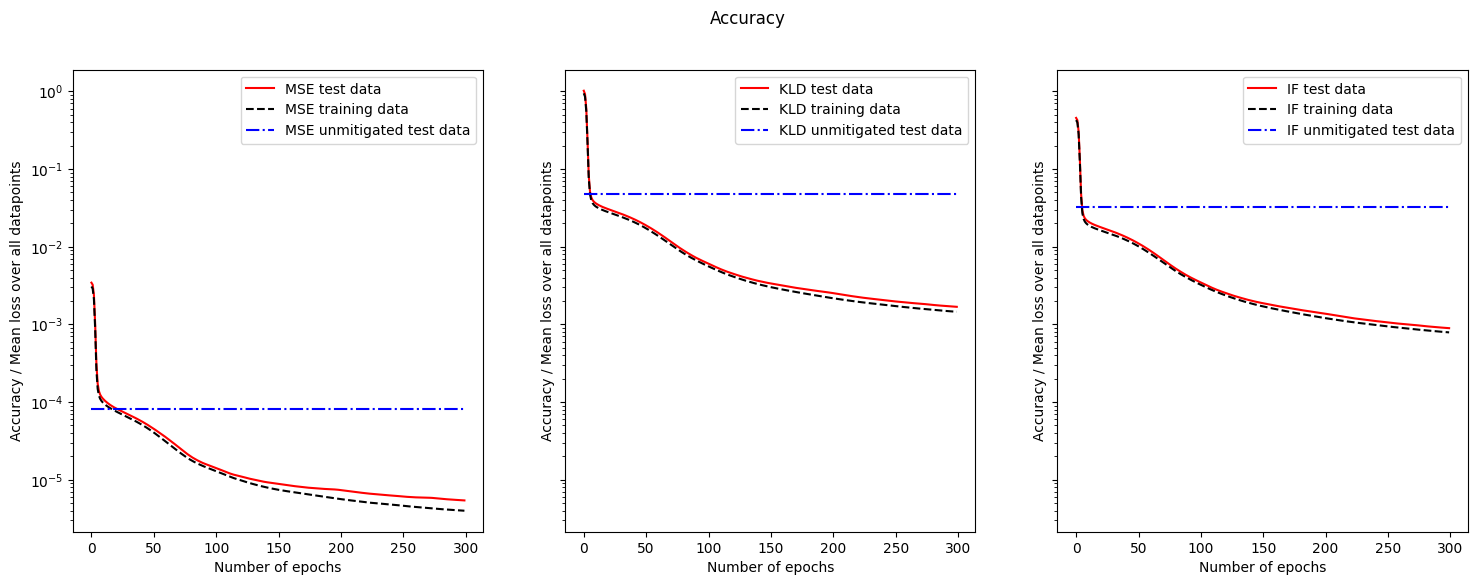

In [ ]:
nQubit = 5
layers = [160,160,160,160,160,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 5*10**-5
training_states = 9900 # originally 9850 but adapted to the batch size
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

L_inv5, POVM5, P5, MSE_data_LI5, KLD_data_LI5, IF_data_LI5 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state5, MSE_data5, KLD_data5, IF_data5 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data5[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data5[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data5[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data5[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data5[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data5[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data5[0],label="IF test data",color="red")
axs[2].plot(i,IF_data5[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data5[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

In [ ]:
print(MSE_data_LI5, KLD_data_LI5, IF_data_LI5)
#print(POVM2)
for element in POVM5:
  print(np.all(np.linalg.eigvals(element) > 0))

[Array(3.7324648e-06, dtype=float32), Array(3.9007186e-06, dtype=float32)] [Array(0.00261542-0.00248387j, dtype=complex64), Array(0.00293784-0.00230111j, dtype=complex64)] [Array(0.00167097-0.00161315j, dtype=complex64), Array(0.00180024-0.00137916j, dtype=complex64)]
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Text(0.5, 0.98, 'NN vs LI improvement')

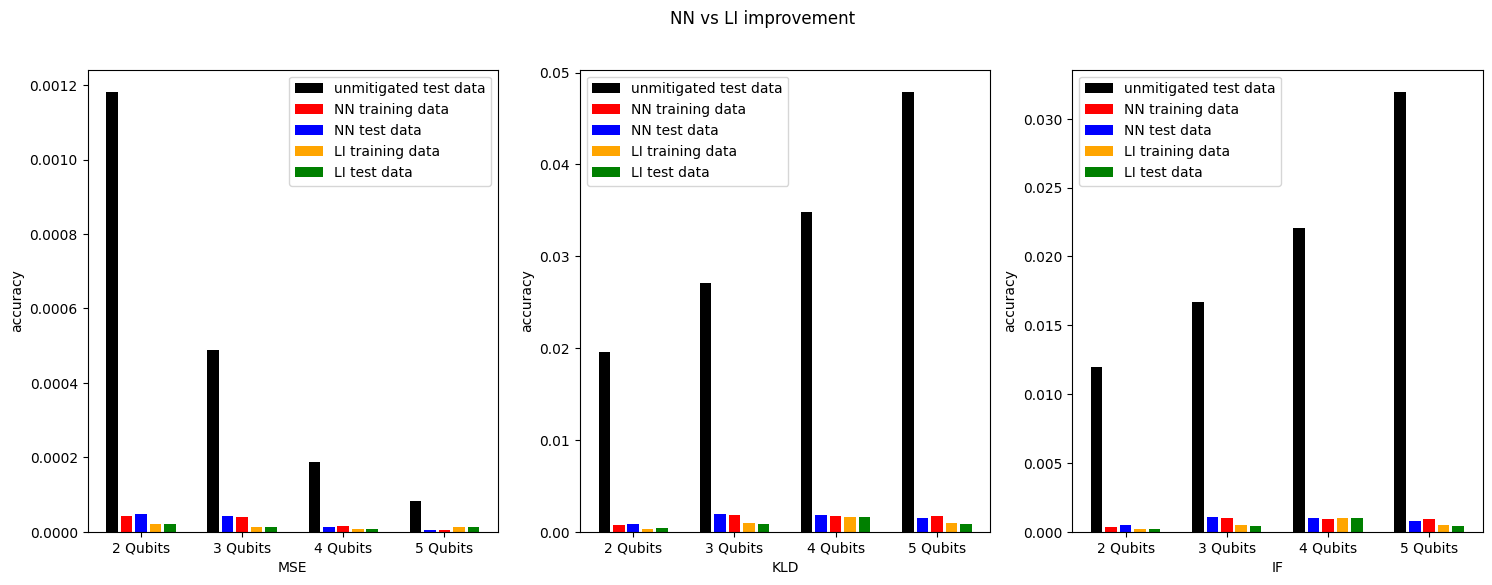

In [ ]:
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

axs[0].bar(0,MSE_data2[2][-1],label="unmitigated test data",color="black")
axs[0].bar(1,MSE_data2[1][-1],label="NN training data",color="red")
axs[0].bar(2,MSE_data2[0][-1],label="NN test data",color="blue")
axs[0].bar(3,MSE_data_LI2[1],label="LI training data",color="orange")
axs[0].bar(4,MSE_data_LI2[0],label="LI test data",color="green")
axs[0].bar(7,MSE_data3[2][-1],color="black")
axs[0].bar(8,MSE_data3[1][-1],color="blue")
axs[0].bar(9,MSE_data3[0][-1],color="red")
axs[0].bar(10,MSE_data_LI3[1],color="orange")
axs[0].bar(11,MSE_data_LI3[0],color="green")
axs[0].bar(14,MSE_data4[2][-1],color="black")
axs[0].bar(15,MSE_data4[1][-1],color="blue")
axs[0].bar(16,MSE_data4[0][-1],color="red")
axs[0].bar(17,MSE_data_LI4[1],color="orange")
axs[0].bar(18,MSE_data_LI4[0],color="green")
axs[0].bar(21,MSE_data5[2][-1],color="black")
axs[0].bar(22,MSE_data5[1][-1],color="blue")
axs[0].bar(23,MSE_data5[0][-1],color="red")
axs[0].bar(24,MSE_data_LI3[1],color="orange")
axs[0].bar(25,MSE_data_LI3[0],color="green")
axs[0].set_xticks([2,9,16,23])
axs[0].set_xticklabels(labels)
axs[0].set_xlabel("MSE")
axs[0].set_ylabel("accuracy")
axs[0].legend()

axs[1].bar(0,KLD_data2[2][-1],label="unmitigated test data",color="black")
axs[1].bar(1,KLD_data2[1][-1],label="NN training data",color="red")
axs[1].bar(2,KLD_data2[0][-1],label="NN test data",color="blue")
axs[1].bar(3,KLD_data_LI2[1],label="LI training data",color="orange")
axs[1].bar(4,KLD_data_LI2[0],label="LI test data",color="green")
axs[1].bar(7,KLD_data3[2][-1],color="black")
axs[1].bar(8,KLD_data3[1][-1],color="blue")
axs[1].bar(9,KLD_data3[0][-1],color="red")
axs[1].bar(10,KLD_data_LI3[1],color="orange")
axs[1].bar(11,KLD_data_LI3[0],color="green")
axs[1].bar(14,KLD_data4[2][-1],color="black")
axs[1].bar(15,KLD_data4[1][-1],color="blue")
axs[1].bar(16,KLD_data4[0][-1],color="red")
axs[1].bar(17,KLD_data_LI4[1],color="orange")
axs[1].bar(18,KLD_data_LI4[0],color="green")
axs[1].bar(21,KLD_data5[2][-1],color="black")
axs[1].bar(22,KLD_data5[1][-1],color="blue")
axs[1].bar(23,KLD_data5[0][-1],color="red")
axs[1].bar(24,KLD_data_LI3[1],color="orange")
axs[1].bar(25,KLD_data_LI3[0],color="green")
axs[1].set_xticks([2,9,16,23])
axs[1].set_xticklabels(labels)
axs[1].set_xlabel("KLD")
axs[1].set_ylabel("accuracy")
axs[1].legend()

axs[2].bar(0,IF_data2[2][-1],label="unmitigated test data",color="black")
axs[2].bar(1,IF_data2[1][-1],label="NN training data",color="red")
axs[2].bar(2,IF_data2[0][-1],label="NN test data",color="blue")
axs[2].bar(3,IF_data_LI2[1],label="LI training data",color="orange")
axs[2].bar(4,IF_data_LI2[0],label="LI test data",color="green")
axs[2].bar(7,IF_data3[2][-1],color="black")
axs[2].bar(8,IF_data3[1][-1],color="blue")
axs[2].bar(9,IF_data3[0][-1],color="red")
axs[2].bar(10,IF_data_LI3[1],color="orange")
axs[2].bar(11,IF_data_LI3[0],color="green")
axs[2].bar(14,IF_data4[2][-1],color="black")
axs[2].bar(15,IF_data4[1][-1],color="blue")
axs[2].bar(16,IF_data4[0][-1],color="red")
axs[2].bar(17,IF_data_LI4[1],color="orange")
axs[2].bar(18,IF_data_LI4[0],color="green")
axs[2].bar(21,IF_data5[2][-1],color="black")
axs[2].bar(22,IF_data5[1][-1],color="blue")
axs[2].bar(23,IF_data5[0][-1],color="red")
axs[2].bar(24,IF_data_LI3[1],color="orange")
axs[2].bar(25,IF_data_LI3[0],color="green")
axs[2].set_xticks([2,9,16,23])
axs[2].set_xticklabels(labels)
axs[2].set_xlabel("IF")
axs[2].set_ylabel("accuracy")
axs[2].legend()

fig.suptitle('NN vs LI improvement')